In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from run_backtest import load_trackers
from utils import clean_stale_prices

from entities import EM_CDS_TRACKER_DICT, FX_TRACKER_DICT
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

In [4]:
OUTPUT_FOLDER = Path(
    r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Dissertação Mestrado\Analysis"
)

def plot_bar_contribution(
    heights: pd.Series,
    title: str,
):
    plt.figure(figsize=(10, 6))
    cumulative_values = np.cumsum(heights) - heights
    plt.bar(
        range(1, len(heights) + 1),
        heights,
        bottom=cumulative_values,
        alpha=0.5,
        align="center",
        label="Explained Variance",
    )

    plt.ylim(0, 1)
    plt.xlabel("Componente Principal", labelpad=10)
    plt.ylabel("Explicação da Variância", labelpad=10)
    plt.title(title, fontweight="bold", pad=20)

    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.75)
    plt.grid(True, which="minor", axis="x", linestyle="--", linewidth=0.75)

    plt.gca().tick_params(axis="x", which="both", length=0)

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    plt.xticks(range(1, len(heights) + 1))
    plt.tight_layout()
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_overleaf/{title}_pca.pdf"),
        bbox_inches="tight",
    )
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_powerpoint/{title}_pca.svg"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()


def plot_historical_correlation(
    rolling_corr: pd.Series,
    total_correlation: float,
    title: str = "Correlação entre a Primeira Componente Principal de FX e a de CDS",
    y_lim: tuple[float, float] = (0, 1),
):
    plt.figure(figsize=(10, 6))
    rolling_corr.plot()
    plt.axhline(
        total_correlation,
        color="red",
        linestyle="--",
        label="Correlação Média do Período",
    )
    plt.grid(True, which="both", axis="both", linestyle="--", linewidth=0.75)
    plt.xlabel(None)
    plt.xlim(rolling_corr.dropna().index.min(), rolling_corr.index.max())
    plt.ylim(*y_lim)
    plt.legend(ncol=2)
    plt.title(title, fontweight="bold", pad=20)
    plt.tight_layout()
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_overleaf/{title}_pca_corr.pdf"),
        bbox_inches="tight",
    )
    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"Charts_powerpoint/{title}_pca_corr.svg"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

In [5]:
cds = load_trackers(EM_CDS_TRACKER_DICT).rename(columns=lambda col: col + "_cds")
fx = load_trackers(FX_TRACKER_DICT).rename(columns=lambda col: col + "_fx")

cds = pd.concat([clean_stale_prices(cds[col].copy()) for col in cds], axis=1)
fx = pd.concat([clean_stale_prices(fx[col].copy()) for col in fx], axis=1)

In [6]:
RETURN_WINDOW = 21

df_cds = (
    np.log(cds)
    .fillna(method="ffill", limit=5)
    .diff(RETURN_WINDOW)
    .dropna(how="all")
    .copy()
)
df_cds = df_cds.loc["2009-12-10":].dropna(how="any", axis=1)
df_cds = (df_cds - df_cds.mean())/ df_cds.std()

df_fx = (
    np.log(fx)
    .fillna(method="ffill", limit=5)
    .diff(RETURN_WINDOW)
    .dropna(how="all")
    .copy()
)
df_fx = df_fx.loc["2004-08-02":].dropna(how="any", axis=1)
df_fx = (df_fx - df_fx.mean()) / df_fx.std()

new_index = df_fx.dropna().index.intersection(df_cds.dropna().index)
df_fx = df_fx.reindex(new_index)
df_cds = df_cds.reindex(new_index)

df_all = pd.concat([df_cds, df_fx], axis=1).dropna()
df_all

,AED_cds,BRL_cds,CNY_cds,CLP_cds,COP_cds,MYR_cds,MXN_cds,PAB_cds,PEN_cds,PHP_cds,...,IDR_fx,INR_fx,MXN_fx,PLN_fx,RUB_fx,SGD_fx,THB_fx,TRY_fx,TWD_fx,ZAR_fx
date,,,,,,,,,,,,,,,,,,,,,
2009-12-10,-5.819582,-0.206005,0.388038,-0.547322,-0.318780,0.354585,0.080446,-0.035651,-0.177502,0.218631,...,-0.193842,-0.207973,0.832668,-0.110559,-0.865124,-0.162914,0.127142,-0.181775,-0.224183,-0.269272
2009-12-11,-5.427209,-0.256373,0.407185,-0.243592,-0.205000,0.241149,0.069002,-0.021606,-0.177527,0.185851,...,-0.267802,-0.206566,0.774056,-0.396211,-0.718141,-0.207723,0.166171,-0.221995,0.052467,-0.218844
2009-12-14,-4.722358,-0.021179,0.464485,-0.209863,0.060486,0.311400,0.338872,0.204458,0.183063,0.491414,...,-0.209723,-0.052235,0.841562,-0.540722,-0.610285,-0.156668,0.198852,-0.175024,0.025167,0.209540
2009-12-15,-4.866107,0.045897,0.599503,-0.159166,0.145627,0.395820,0.360937,0.401832,0.257781,0.700108,...,-0.533987,-0.250560,0.904447,-1.060353,-0.676033,-0.378194,0.161989,-0.231301,-0.009642,0.210204
2009-12-16,-4.803743,-0.180770,0.329033,-0.496466,-0.072396,0.324959,-0.055102,-0.007791,-0.072566,0.297101,...,-0.372913,-0.467505,0.740645,-1.152246,-0.825312,-0.483906,-0.013698,-0.301495,-0.550304,0.064418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-02,-0.255618,0.747795,0.085357,0.224413,0.233109,0.058053,0.433707,1.607927,0.436472,0.157997,...,0.489299,-0.019234,0.628925,-0.114557,-1.219884,0.679023,2.069391,0.572135,-0.005987,0.789305
2024-10-03,-0.305256,0.625419,0.038625,0.113966,0.475459,0.058074,0.351854,1.705236,0.414036,0.253089,...,0.064531,-0.011123,0.346335,-0.359148,-0.945781,0.122432,1.428502,0.599901,0.070005,0.414909
2024-10-04,-0.702692,0.724604,0.038580,0.237981,0.730791,0.058011,0.530961,1.726617,0.526865,0.253003,...,-0.185799,-0.018026,1.233074,-0.478031,-0.866206,-0.280290,0.942254,0.539472,-0.164588,0.383187


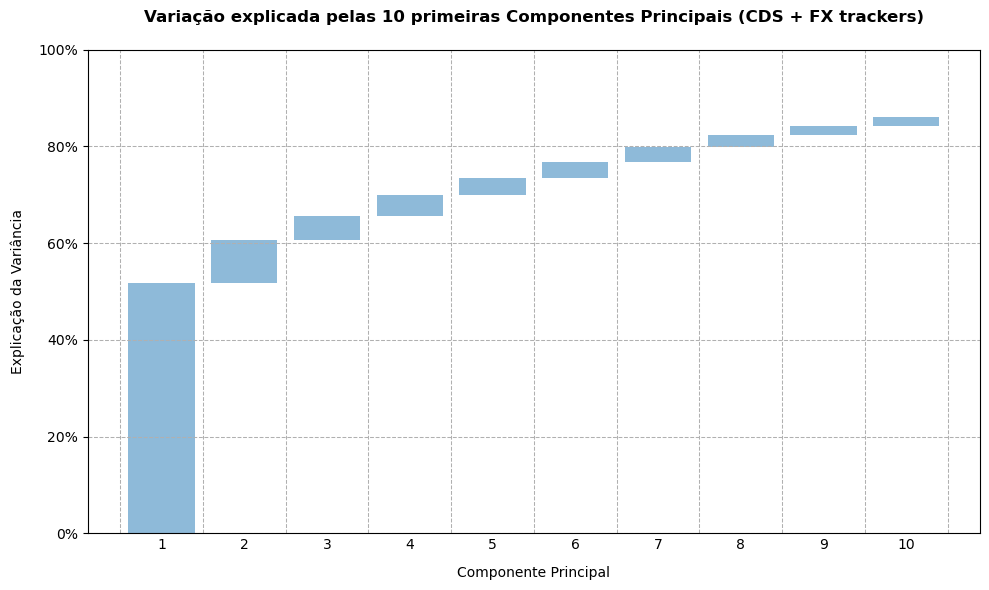

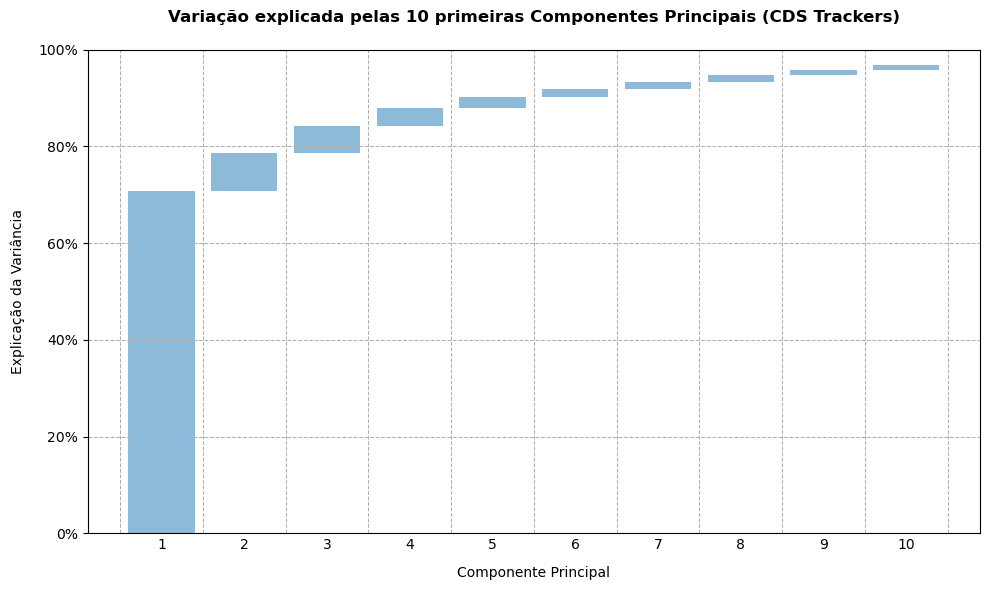

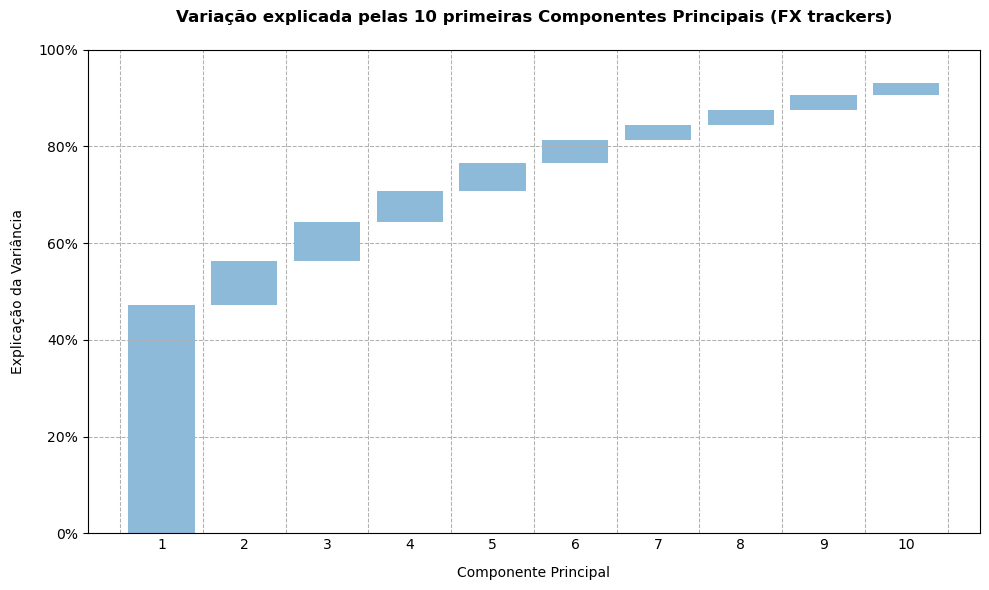

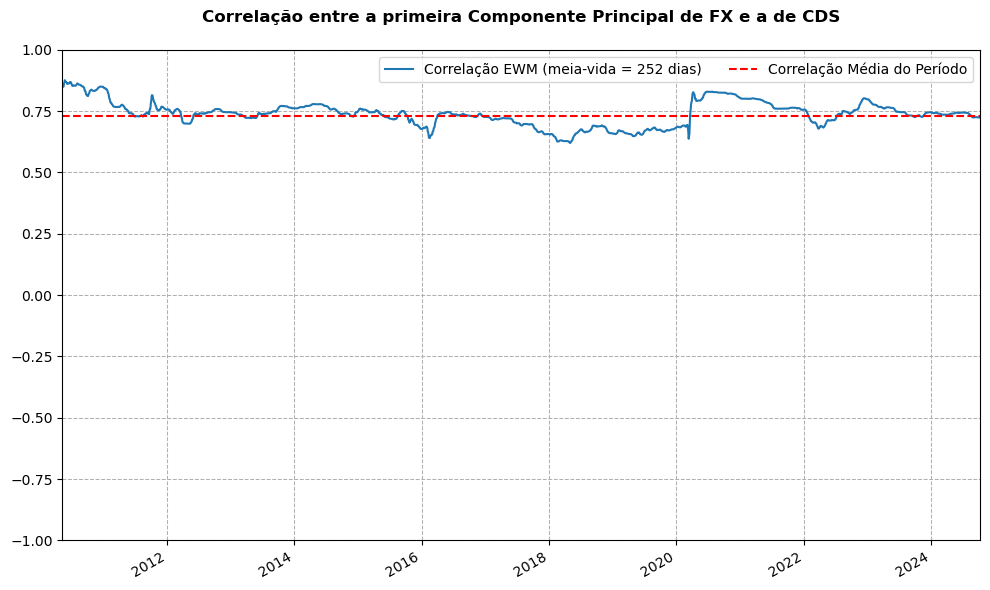

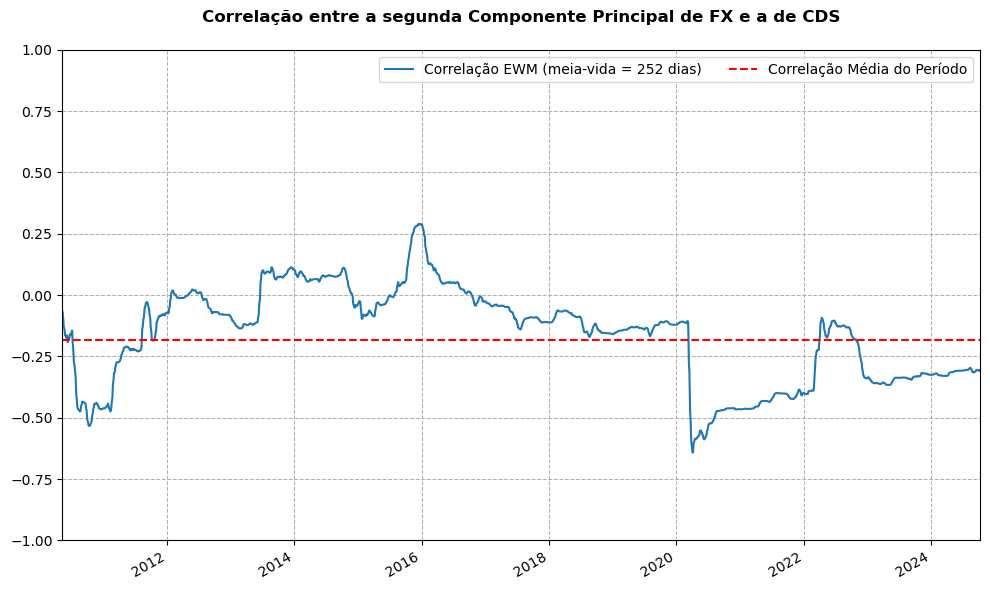

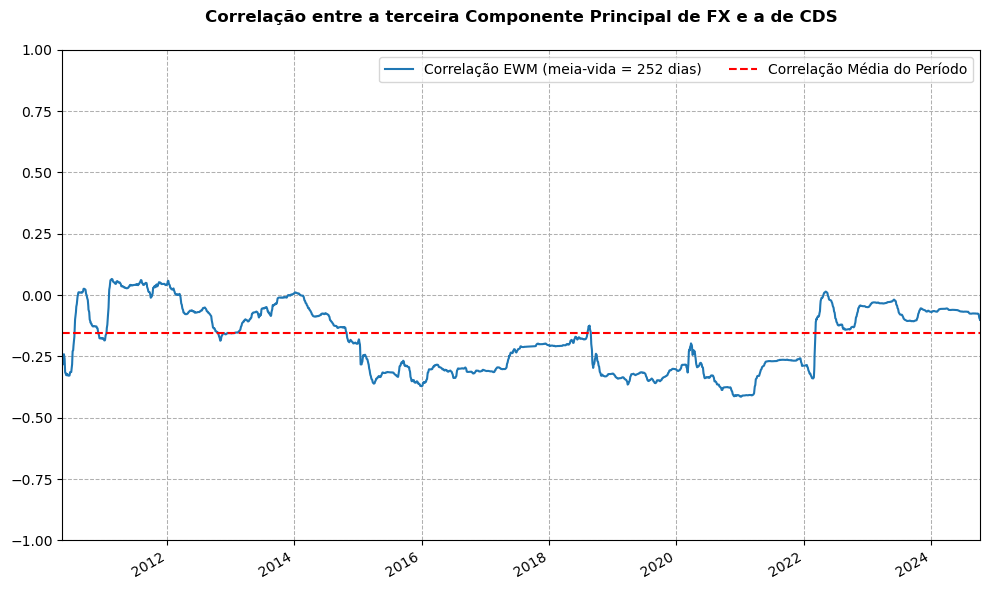

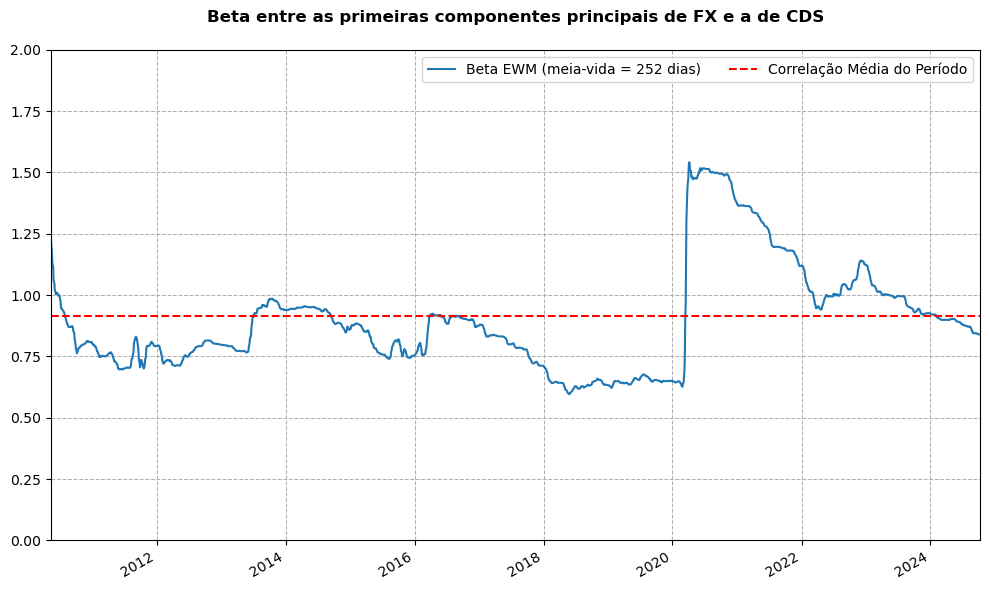

In [7]:
pca_all = PCA(n_components=10).fit(df_all)
plot_bar_contribution(
    pca_all.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (CDS + FX trackers)",
)
########################################################################################
pca_cds = PCA(n_components=10).fit(df_cds.dropna())
explained_variance_ratio = pca_cds.explained_variance_ratio_
plot_bar_contribution(
    pca_cds.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (CDS Trackers)",
)
########################################################################################
pca_fx = PCA(n_components=10).fit(df_fx.dropna())
explained_variance_ratio = pca_fx.explained_variance_ratio_
plot_bar_contribution(
    pca_fx.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (FX trackers)",
)
########################################################################################
pca_1_fx = pd.DataFrame(pca_fx.fit_transform(df_fx), index=new_index).iloc[:, 0]
pca_1_cds = pd.DataFrame(pca_cds.fit_transform(df_cds), index=new_index).iloc[:, 0]
plot_historical_correlation(
    pca_1_cds.ewm(halflife=252)
    .corr(pca_1_fx)
    .iloc[100:]
    .rename("Correlação EWM (meia-vida = 252 dias)"),
    pca_1_cds.corr(pca_1_fx),
    title="Correlação entre a primeira Componente Principal de FX e a de CDS",
    y_lim=(-1, 1),
)
########################################################################################
pca_2_fx = pd.DataFrame(pca_fx.fit_transform(df_fx), index=new_index).iloc[:, 1]
pca_2_cds = pd.DataFrame(pca_cds.fit_transform(df_cds), index=new_index).iloc[:, 1]
plot_historical_correlation(
    pca_2_cds.ewm(halflife=252)
    .corr(pca_2_fx)
    .iloc[100:]
    .rename("Correlação EWM (meia-vida = 252 dias)"),
    pca_2_cds.corr(pca_2_fx),
    title="Correlação entre a segunda Componente Principal de FX e a de CDS",
    y_lim=(-1, 1),
)
########################################################################################
pca_3_fx = pd.DataFrame(pca_fx.fit_transform(df_fx), index=new_index).iloc[:, 2]
pca_3_cds = pd.DataFrame(pca_cds.fit_transform(df_cds), index=new_index).iloc[:, 2]
plot_historical_correlation(
    pca_3_cds.ewm(halflife=252)
    .corr(pca_3_fx)
    .iloc[100:]
    .rename("Correlação EWM (meia-vida = 252 dias)"),
    pca_3_cds.corr(pca_3_fx),
    title="Correlação entre a terceira Componente Principal de FX e a de CDS",
    y_lim=(-1, 1),
)
########################################################################################
plot_historical_correlation(
    (pca_1_cds.ewm(halflife=252).cov(pca_1_fx) / pca_1_fx.ewm(halflife=252).var())
    .iloc[100:]
    .rename("Beta EWM (meia-vida = 252 dias)"),
    pca_1_cds.cov(pca_1_fx) / pca_1_fx.var(),
    y_lim=(0, 2),
    title="Beta entre as primeiras componentes principais de FX e a de CDS",
)

# OLD

In [6]:
from scipy import stats
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(pca_1_cds, pca_1_fx)

# r_value is the correlation coefficient, so R² is r_value squared
r_squared = r_value**2

print(f"R²: {r_squared}")

R²: 0.5335863738075001


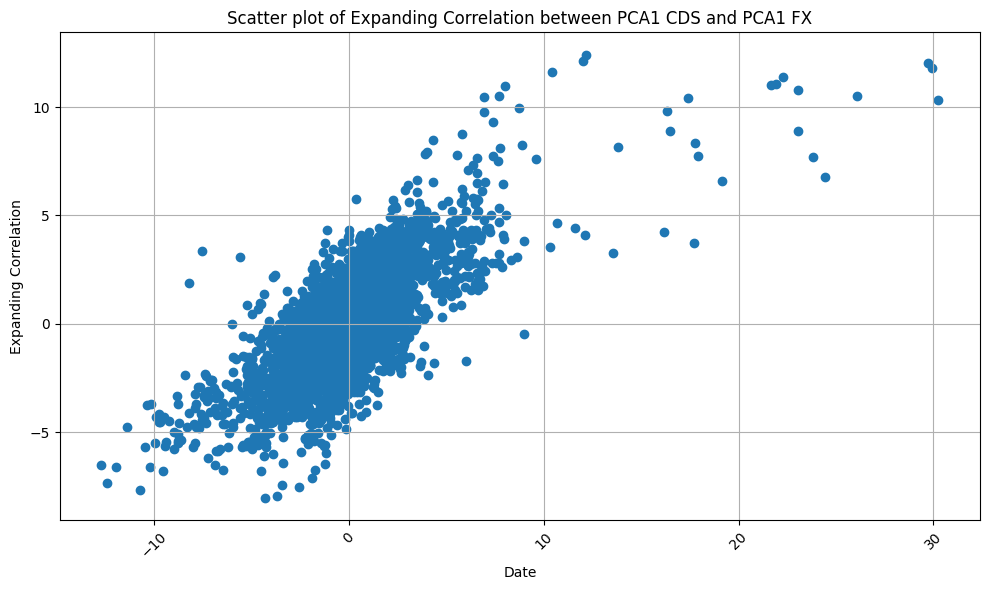

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_1_cds, pca_1_fx.reindex(pca_1_cds.index))
plt.title("Scatter plot of Expanding Correlation between PCA1 CDS and PCA1 FX")
plt.xlabel("Date")
plt.ylabel("Expanding Correlation")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()